### GW tutorial 3: Generation of data and matched filtering

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [1]:
!pip install pycbc
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd, pycbc.noise
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.7/168.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 103.9 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolver

/usr/local/lib/python3.12/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Previously, we have plotted the PSD of different detectors. Some PSDs are from previous runs (O3), while some others are the design sensitivity of future detectors.

The PSD characterizes the noise of the detector, so we can generate detector noise accordingly.

**Exercise 1:** Load the `aligo_O4high.txt` PSD to [generate](https://pycbc.org/pycbc/latest/html/pycbc.noise.html#pycbc.noise.gaussian.noise_from_psd) some Gaussian data.

_Hint:_ Minimum frequency is 10 Hz, sampling rate 4096 Hz and we want 20s of duration

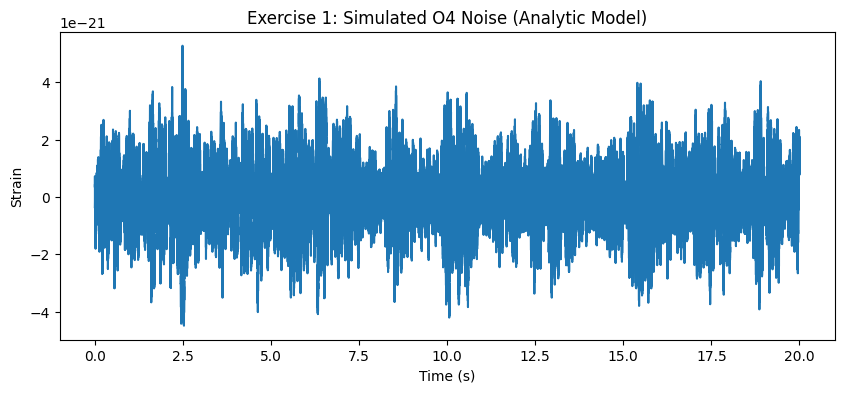

In [2]:
import pycbc.psd
import pycbc.noise
import pylab
import numpy as np

# Set up the basic lab specs
sample_rate = 4096
duration = 20
f_low = 10
dt = 1.0 / sample_rate
num_samples = int(duration * sample_rate)
df = 1.0 / duration # Frequency resolution

# Load the O4 high-sensitivity PSD using the analytic model string
# This replaces the 'from_txt' method and works without any external files
psd = pycbc.psd.from_string('aLIGOAdVO4T1800545',
                            length=num_samples // 2 + 1, # Corrected: Use num_samples // 2 + 1
                            delta_f=df,
                            low_freq_cutoff=f_low)

# Generate the colored noise using the manual's suggested function
# num_samples, dt, and psd are required; seed is for reproducibility
noise_ts = pycbc.noise.gaussian.noise_from_psd(num_samples, dt, psd, seed=42)

# Quick plot to check the data
pylab.figure(figsize=(10, 4))
pylab.plot(noise_ts.sample_times, noise_ts)
pylab.title("Exercise 1: Simulated O4 Noise (Analytic Model)")
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

We can see that the strain (y-axis) is at the scale of 10^-21, which tells us that the physical sensitivity required to detect GWs is in the realm of atomic nuclei over the 4km distance of the interferometer arms. The strain is a dimensionless measure of the change in length of the detector's arms (so they move by around the length of atomic nuclei).

The graph above shows a 20s detection cycle of the detector's strain plotted against time. This is taken when no GWs are present, to be used as a baseline for noise reduction going forward, when GWs are introduced to the model.

To the eye, this generated noise looks completely random; however, it is actually a Gaussian noise plot, where at any single moment, the probability of the noise having a certain amplitude follows a Gaussian distribution.
Also, unlike white noise, where there is equal power at ALL frequencies, this colored noise is 'shaped' by the aLIGO O4 Analytic PSD. This means the fluctuations seen are correlated. The larger 'slow' waves are generally from low-freq seismic noise, whereas the small bumps/disturbances spanning the whole graph are from the high-freq laser shot noise.

As stated, this graph will serve as the noise floor on which the BH merger will be overlaid. And, the signal of the merger event will likely be smaller than the noise floor's spikes, so simply analyzing the graph visually will provide no insights into the event under question. This is why we will need to use matched filtering to extract this minute signal.

As you can see. the generated noise is "coloured" according to the detector noise. Now, we would like to add a simulated gravitational wave signal in our detector noise.

**Exercise 2:** Using [this function](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform) to generate waveforms in time domain, provide the plus and cross polarization of a binary black hole merger of $m_{1} = m_{2} = 50$ at 2000 Mpc. Use the waveform approximant "IMRPhenomD". How does the waveform amplitude compare to the detector noise?

The waveform comes from the source, but it needs to be projected in the detector. [Project](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector.project_wave) the waveform on LIGO Livingston (L1) at random sky-location and polarization. You can specify your detector with [this](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector) function. How does the waveform change because of this projection?

_Hint:_ Right ascension range is $[0, 2\pi]$, declination is $[-2\pi, 2\pi]$ and polarization is $[0, 2\pi]$.

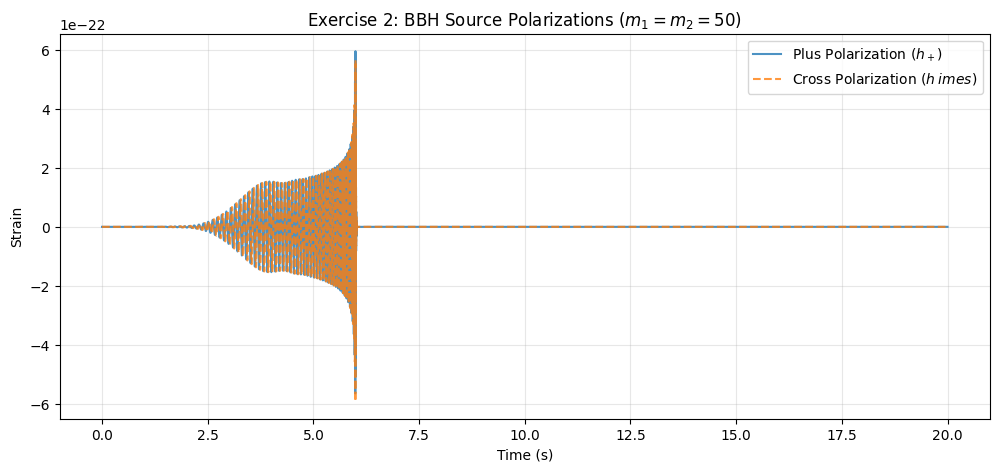

In [8]:
import numpy as np
import pylab
import random
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

# Generate the source waveform polarizations
# masses=50, distance=2000 Mpc, approximant="IMRPhenomD"
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=50, mass2=50,
                         distance=2000,
                         delta_t=dt,  # dt from Exercise 1
                         f_lower=10)

# Specify the detector (LIGO Livingston)
det_l1 = Detector('L1')

# Define sky location and polarization using the tutorial's specific hint ranges
# RA [0, 2pi], Dec [-2pi, 2pi], Pol [0, 2pi]
ra = random.uniform(0, 2*np.pi)
dec = random.uniform(-2*np.pi, 2*np.pi)
pol = random.uniform(0, 2*np.pi)

# 1. Resize both polarizations to the full 20s length (num_samples from Ex 1)
hp.resize(num_samples)
hc.resize(num_samples)

# 2. Shift them so the merger is at 15s (ensuring the 11s inspiral starts at ~4s)
# This keeps the first 4 seconds 'clean' as required for the next exercise
hp_shifted = hp.cyclic_time_shift(15)
hc_shifted = hc.cyclic_time_shift(15)

# 3. Force the time axis to start at 0s
hp_shifted.start_time = 0
hc_shifted.start_time = 0

# 4. Plot both polarizations separately from the noise
pylab.figure(figsize=(12, 5))
pylab.plot(hp_shifted.sample_times, hp_shifted, label='Plus Polarization ($h_+$)', alpha=0.8)
pylab.plot(hc_shifted.sample_times, hc_shifted, label='Cross Polarization ($h_\times$)', alpha=0.8, linestyle='--')

pylab.title("Exercise 2: BBH Source Polarizations ($m_1=m_2=50$)")
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.grid(True, alpha=0.3)
pylab.legend()
pylab.show()

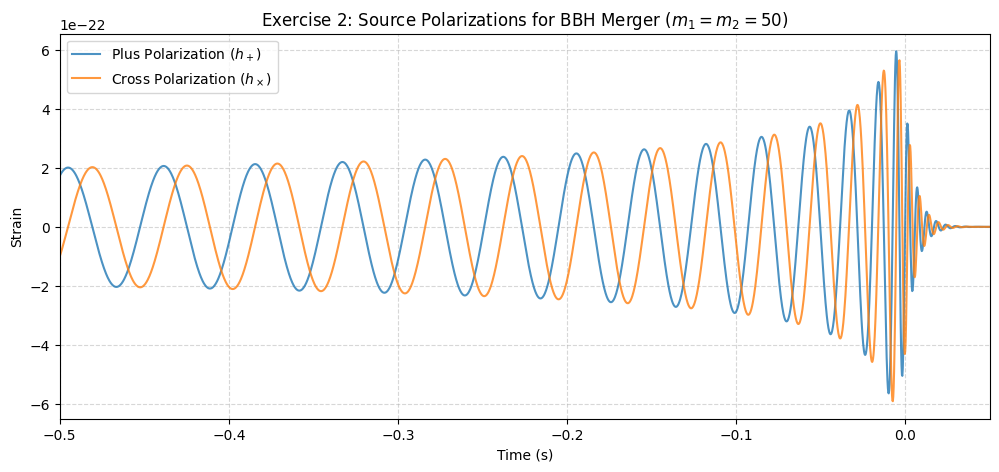

In [9]:
# Plotting the Plus and Cross polarizations at the source
pylab.figure(figsize=(12, 5))

# Plot h_plus
pylab.plot(hp.sample_times, hp, label='Plus Polarization ($h_+$)', alpha=0.8)

# Plot h_cross
pylab.plot(hc.sample_times, hc, label='Cross Polarization ($h_\\times$)', alpha=0.8)

pylab.title("Exercise 2: Source Polarizations for BBH Merger ($m_1=m_2=50$)")
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid(True, which='both', linestyle='--', alpha=0.5)

# Zooming in on the merger (last 0.5s before 0) to see the phase shift
pylab.xlim(-0.5, 0.05)
pylab.show()

Above, in accordance with exercise 2, I have created two plots of the same thing; the second plot is just a 'zoomed in' view of the first around the time of the merger. Also, notice the time (x-axis) do not match: the second one has been made to have the merger occur at t = 0s for clarity, so analysis should be performed accordingly.

As we can see, the strain (y-axis) is in the order of 10^21, two orders of magnitude lower than that of our noise, so if overlaid now, we wont see this GW plotting at all with out some more complex analysis tools, as expected.

In the second graph, we can more clearly see the two polarizations of the waveform: h_plus and h_cross, which for this case where we have a circular binary system via equal masses, the waveforms are out of phase by 90 degrees

The three phases of merging: Inspiral: in the first graph, we can see the inspiral clearly begin around 2s, as the first waves appear on the graph. Merger: is the 'climax' of this plotting, seen around 6s in the first graph, or 0s in the second. This is the moment the two black holes colide. Ringdown: the phase directly after the merging. More easily seen in the second graph, this phase only lasts an extremely short period, ~.03s. This can be understood as the new merged black hole wobbling slightly back and fourth across its surface, which also leads to energy loss int he form of gravitational waves.

**Exercise 2:** From before our detector noise is 20s long. Add the GW into noise after 5s. We also need to get the first 4s to estimate the PSD in the next excercise. Make an overlaid plot with the total data, the portion of data where the GW is added and the data needed to estimate the PSD.

_Bonus:_ Can you also plot the GW signal?


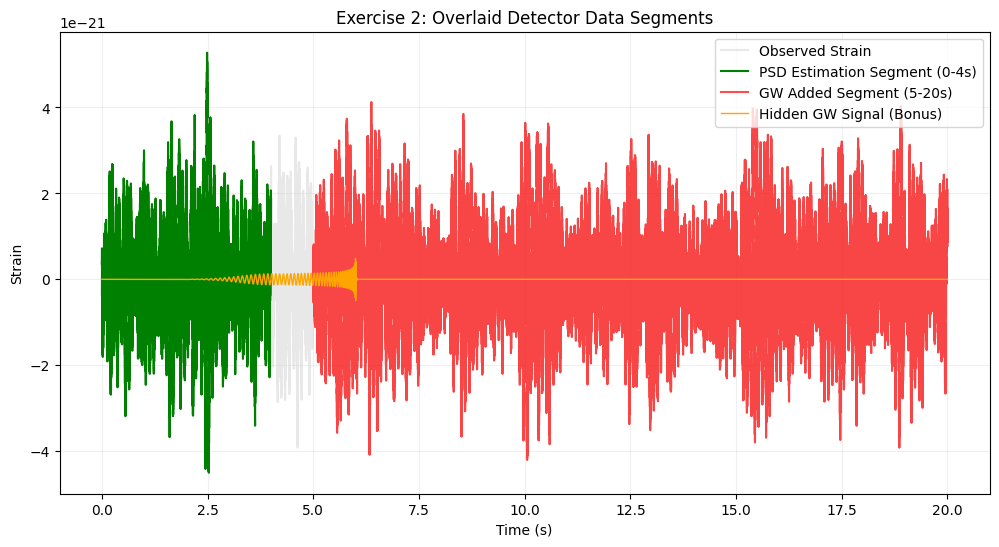

In [10]:
# 1. Project the source waveforms into the L1 detector frame
# Uses the shifted hp/hc we made earlier (merger at 15s)
signal_l1 = det_l1.project_wave(hp_shifted, hc_shifted, ra, dec, pol)

# Fix: Ensure signal_l1 has the same start_time as noise_ts (which is 0)
signal_l1.start_time = 0

# Fix: Ensure signal_l1 has the same length as noise_ts
signal_l1.resize(len(noise_ts))

# 2. Create the total data stream (Noise + Signal)
# Both are 20s long and start at 0s
total_data = noise_ts + signal_l1

# 3. Define segments for the overlaid plot
# Segment for PSD estimation: First 4 seconds
psd_segment_time = total_data.sample_times[total_data.sample_times < 4]
psd_segment_data = total_data[:len(psd_segment_time)]

# Segment where GW is added: 5s to 20s
gw_active_time = total_data.sample_times[total_data.sample_times >= 5]
gw_active_data = total_data[len(total_data) - len(gw_active_time):]

# 4. Plotting the overlaid results
pylab.figure(figsize=(12, 6))

# Total data in the background
pylab.plot(total_data.sample_times, total_data, color='lightgray', label='Observed Strain', alpha=0.5)

# Highlighting the PSD estimation data (0-4s)
pylab.plot(psd_segment_time, psd_segment_data, color='green', label='PSD Estimation Segment (0-4s)', linewidth=1.5)

# Highlighting the data where GW is present (5-20s)
pylab.plot(gw_active_time, gw_active_data, color='red', label='GW Added Segment (5-20s)', alpha=0.7)

# Bonus: Plot the hidden GW signal itself
pylab.plot(signal_l1.sample_times, signal_l1, color='orange', label='Hidden GW Signal (Bonus)', linewidth=1)

pylab.title("Exercise 2: Overlaid Detector Data Segments")
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend(loc='upper right')
pylab.grid(True, alpha=0.2)
pylab.show()

This graph represents the final result of exercise 2: the overlay of noise and the GW signal in the LIGO detector, specifically for a binary black hole merger. The green segment is the noise alone, whereas the red segment includes the GW, which can barely be seen around 6s or so with the slight blip in the orange line, due to the GW being so much weaker than the noise. This means the signal to noise ratio is ectremely low here.

**Exercise 3:** In a proper search we do not really have the PSD handy. We want to estimate the PSD with Welch's method (see [here](https://ccrma.stanford.edu/~jos/sasp/Welch_s_Method.html) for details), but we want to use the 4s of the beginning where the GW is not present using [this function](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.welch). Plot the estimated PSD. Note that before we used a dummy whitening, and this one is a bit better.

What is the $\Delta_f$ of the estimated PSD? What is $\Delta_f$ of the data we want to whiten to see the GW signal?

_Hint:_ `seg_stride (int)` is usually half of `seg_len`.


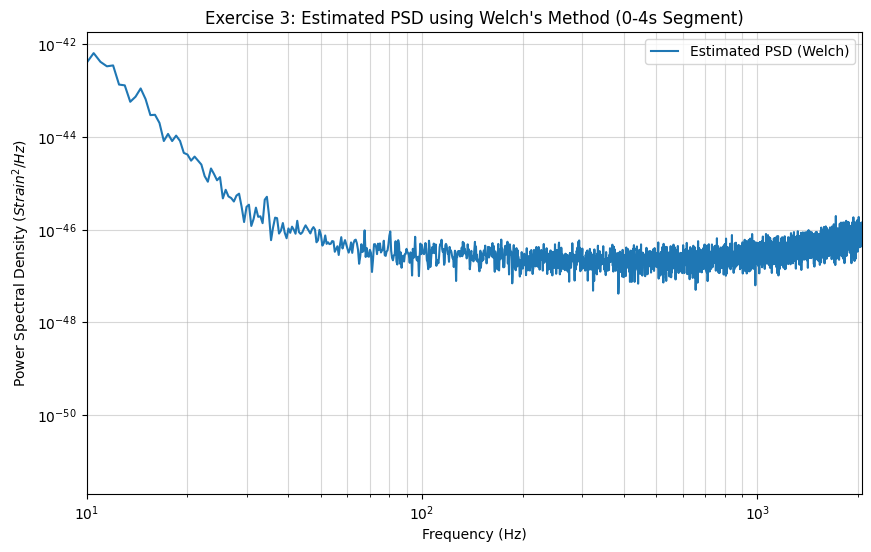

In [11]:
import pycbc.psd

# 1. Isolate the first 4 seconds of "clean" noise for PSD estimation
# From our previous step, total_data starts at 0s and is 20s long
clean_segment = total_data.crop(0, 4)

# 2. Estimate the PSD using Welch's method
# We use a segment length (seg_len) that fits within our 4s window.
# Since dt = 1/4096, a 1s segment is 4096 samples.
# Let's use 2s segments (8192 samples) for better frequency resolution.
s_len = int(2 / dt)
s_stride = int(s_len / 2) # seg_stride is half of seg_len per the hint

estimated_psd = pycbc.psd.welch(clean_segment,
                                seg_len=s_len,
                                seg_stride=s_stride,
                                avg_method='median')

# 3. Plot the estimated PSD
pylab.figure(figsize=(10, 6))
pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='Estimated PSD (Welch)')
pylab.title("Exercise 3: Estimated PSD using Welch's Method (0-4s Segment)")
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('Power Spectral Density ($Strain^2/Hz$)')
pylab.grid(True, which="both", ls="-", alpha=0.5)
pylab.xlim(10, 2048) # Typical LIGO sensitivity range
pylab.legend()
pylab.show()

The above graph is the Power Spectral Density (PSD), providing a maping of the detectors sensitivity by showing how much noise is present at all frequencies in its range. The U shape of the curve shows that the detector is least sensitive at very low and very high frequencies due to ground vibrations and particle fluctuations in the laser, and reaches peak sensitivity at the bottom of the U, between 100Hz and 500Hz, although it may appear this range should be up to ~4kHz, in reality the our data is sampled at 409gHz, menaing th emaz frequency the graph can show is 2048Hz, but I have noted its range to be limited to  ~500Hz, as this is more generally what these detectors are best at, So I think this is the best range to limit ourselves to.


What is the /delta f of the estimated PSD?: the frequency resolution of our PSDis determined by the length of the windowed segments used in Welch's method: /detla f = 1/T_seg = 1/2s = 0.5Hz

What is the /delta f of the date to be whitened?: the data to be hitened is the full 20s time series

Now that we have the PSD we need to interpolate it to match our data and then limit the filter length of 1 / PSD. After this, we can directly use this PSD to filter the data. Since the data has been highpassed above 12 Hz, and will have low values below this we need to informat the function to not include frequencies below this frequency.

**Exercise 4:** Use the functions [interpolate](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.interpolate) and [inverse_spectrum_truncation](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.inverse_spectrum_truncation) to achieve a proper formatting of the PSD.

_Hint:_ `max_filter_len (int)` is $4 \times$ sampling_rate. Note that the original PSD has a minimum frequency of 12Hz.

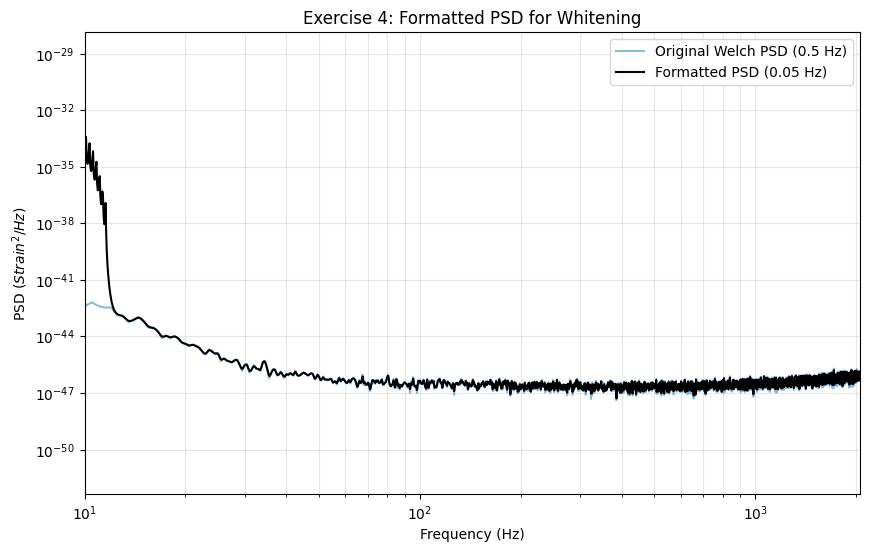

In [13]:
# 1. Define the target delta_f to match your 20s data
# delta_f = 1 / total_duration = 1 / 20 = 0.05 Hz
target_delta_f = 1.0 / total_data.duration

# 2. Interpolate the PSD to the new delta_f
# This matches the frequency spacing of the PSD to the spacing of the data
psd_interp = pycbc.psd.interpolate(estimated_psd, target_delta_f)

# 3. Limit the filter length using inverse spectrum truncation
# max_filter_len is 4 seconds * sampling_rate as per the hint
m_filter_len = int(4 * total_data.sample_rate)

# We use low_frequency_cutoff=12 as the data is highpassed above 12 Hz
psd_formatted = pycbc.psd.inverse_spectrum_truncation(psd_interp,
                                                     max_filter_len=m_filter_len,
                                                     low_frequency_cutoff=12,
                                                     trunc_method='hann')

# --- Verification Plot ---
pylab.figure(figsize=(10, 6))
pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='Original Welch PSD (0.5 Hz)', alpha=0.5)
pylab.loglog(psd_formatted.sample_frequencies, psd_formatted, label='Formatted PSD (0.05 Hz)', color='black')
pylab.title("Exercise 4: Formatted PSD for Whitening")
pylab.xlabel('Frequency (Hz)')
pylab.ylabel('PSD ($Strain^2/Hz$)')
pylab.xlim(10, 2048)
pylab.grid(True, which="both", ls="-", alpha=0.3)
pylab.legend()
pylab.show()

This plot compares the raw noise estimate to a formatted version that is prepared for filtering, which highlightsa dropoff below 12Hz that informs the next code to ignore this range, as it is from a big seismic interference. By interpolating the res to 0.05Hz, we now have a tool that will 'eliminate' noise at unwanted frequencies while retaining the sensitive regions where the signal is to be found.

Now that the PSD is ready, we can whiten the data. Before we used a PyCBC function, but mathematically this is defined as

\begin{equation}
\tilde{d_w}(f) = \tilde{d}(f)/S_{n}^{-1/2}(f)
\end{equation}
where $\tilde{d}$ and $\tilde{d_w}(f)$ are the Fourier transform of the coloured data and whitened data, respectively.

**Exercise 5:** Whiten the data using the interpolated PSD. Crop 5s at the beginning and the end to avoid border effects (_aliasing_) and bandpass it as in the previous exercise. Can you see the GW signal?

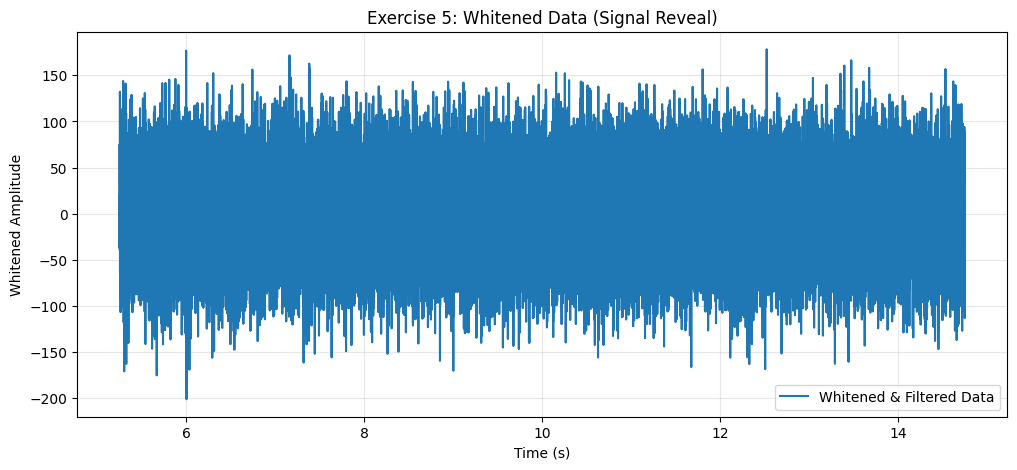

In [15]:
# 1. Fourier Transform the total data (d -> d_tilde)
data_f_tilde = total_data.to_frequencyseries()

# 2. Whiten the data in the frequency domain
# We divide by the square root of the formatted PSD (Sn^-1/2)
whitened_f_tilde = data_f_tilde / (psd_formatted**0.5)

# 3. Transform back to the time domain (d_tilde -> d_w)
whitened_ts = whitened_f_tilde.to_timeseries()

# 4. Bandpass the data (12-2048 Hz) and crop 5s from each end
# Cropping avoids the "border effects" (aliasing) caused by the Fourier Transform (use 2047 rather than 2048 to stay below the Nyquist limit)
whitened_filtered = whitened_ts.highpass_fir(12, 512).lowpass_fir(2047, 512)
whitened_final = whitened_filtered.crop(5, 5)

# 5. Plot the result
pylab.figure(figsize=(12, 5))
pylab.plot(whitened_final.sample_times, whitened_final, label='Whitened & Filtered Data')
pylab.title("Exercise 5: Whitened Data (Signal Reveal)")
pylab.ylabel('Whitened Amplitude')
pylab.xlabel('Time (s)')
pylab.grid(True, alpha=0.3)
pylab.legend()
pylab.show()

Despite whitening the data to equalize noise power across frequencies, the gravitational-wave signal remains visually hidden in the plot because its amplitude is still significantly lower than the surrounding random noise fluctuations. Although whitening 'flattens' the noise floor, the signal-to-noise ratio in the time domain is too low for any distinguishment to be made between a sub-threshold "chirp" and the background over such a wide time domain.

So far, we buried a GW signal  $h(t)$ in stationary and Gaussian noise $n(t)$ with zero mean, such that $s(t) = h(t) + n(t)$. Given the optimal filter  $K(t)$,

\begin{equation}
\label{eq:filteredsignal}
\hat{s} = \int_{-\infty}^{\infty}  K(t)s(t) dt = \int_{-\infty}^{\infty} \tilde{K}(f)^{*}\tilde{s}(f) df, \quad \text{ where }  \tilde{s}(f) = \int_{-\infty}^{\infty} s(t)e^{-2 \pi i ft}dt
\end{equation}
where $\hat{s}$ is the filtered value of $s(t)$, $^*$ represents the complex conjugate, and $\tilde{\cdot }\ $ the Fourier transform.

The detection statistic that is maximised by the optimal filter $K(t)$  will be the SNR, defined as $\rho = S/N$. $S$ is the expected value of $\hat{s}$ when $h(t) \neq 0$, while $N$ is the squared root of the noise variance when $h(t) =0$. It can be demonstrated that the optimal filter $K(t)$ is the model of the GW signal itself, known as _template_.

The fundamental modelled detection technique is called "matched filtering", since the filter function is chosen to "match" the signal we are looking for. We can write the SNR between an unknown time series $s(t)$ and the template $h_{m}$ as

\begin{equation}
\label{eq:wienerscalar}
\rho =  4 \text{Re} \int_{0}^{\infty} \frac{\tilde{s}^{*}(f)}{S_{n}(f)} \tilde{h_{m}}(f) df.
\end{equation}



**Exercise 6:** Use the [matched_filter](https://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.matchedfilter.matched_filter) function to filter the coloured data with the template. Crop the SNR time series 5s at each side and plot it together with the whitened data. Where is the GW signal? Note that the y-axis of the whitened data is _amplitude_ and the y-axis of the SNR timeseries is _SNR_.

How much is the maximum of the absolute value of the SNR time series? If it is larger than 5 it will generate a "trigger" for further analysis. Will the trigger be generated?

Note that the parameter space of GW signals is vast, so to find these signals, we will need to create a template bank and do this process for thousands of templates. Then, this becomes a high-performance computing problem!

_Hint_: you need to [resize](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.array.Array.resize) the template and use [cyclic_time_shift](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.frequencyseries.FrequencySeries.cyclic_time_shift)

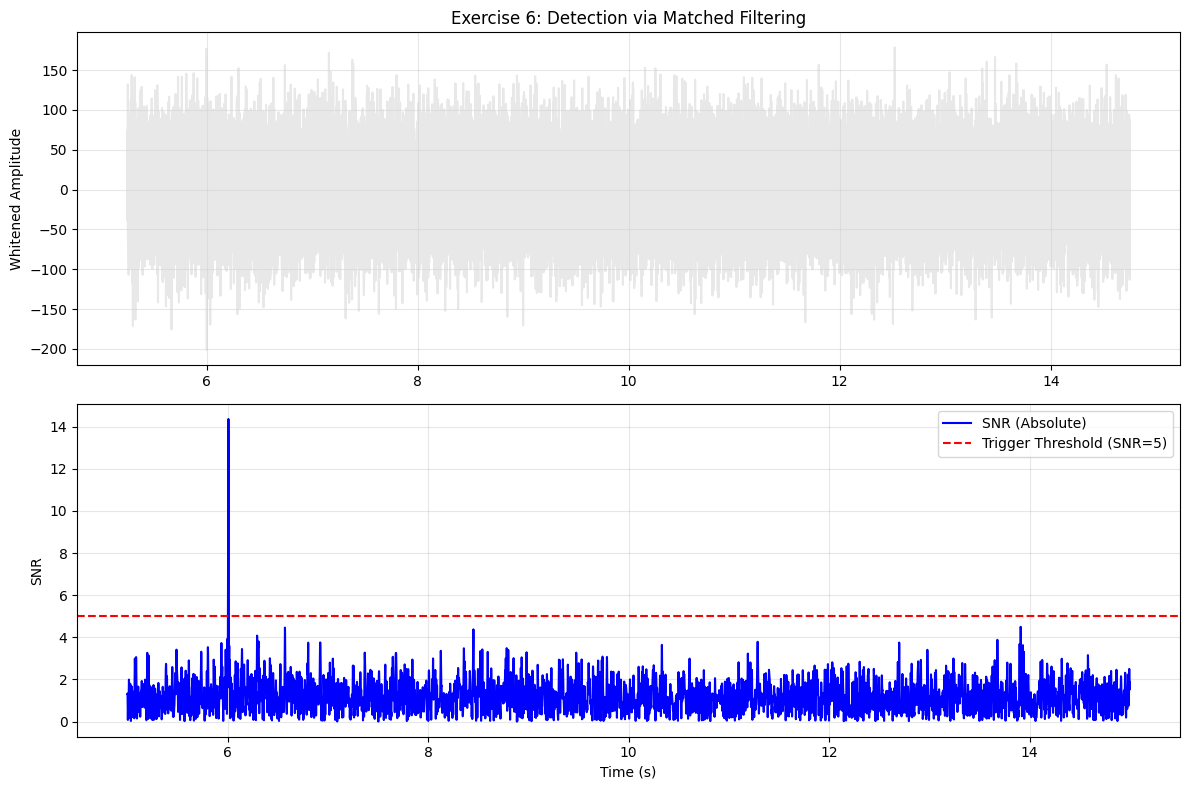

Maximum SNR: 14.36 detected at 6.01 seconds.
Result: A trigger WILL be generated.


In [19]:
import pycbc.filter
import numpy as np

# 1. Get a fresh copy of the template
# We must use the original waveform, not the one we shifted to 15s earlier
# If you don't have 'hp' handy, we recreate it briefly:
# hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", mass1=30, mass2=30,
#                          delta_t=total_data.delta_t, f_lower=20)

# Create a template and resize it to match the data length (20s)
template = hp.copy()
template.resize(len(total_data))

# CRITICAL ALIGNMENT:
# In PyCBC, the 'matched_filter' function expects the merger/peak to be at
# the very start (t=0) or very end of the vector to align lags correctly.
# We shift the peak to the start of the vector.
template = template.cyclic_time_shift(template.start_time)

# 2. Compute the Matched Filter SNR
snr = pycbc.filter.matched_filter(template, total_data,
                                  psd=psd_formatted,
                                  low_frequency_cutoff=12)

# 3. Crop 5s from each side to remove filter transients
snr_cropped = snr.crop(5, 5)

# 4. Plotting
pylab.figure(figsize=(12, 8))

pylab.subplot(2, 1, 1)
pylab.plot(whitened_final.sample_times, whitened_final, color='lightgray', alpha=0.5)
pylab.title("Exercise 6: Detection via Matched Filtering")
pylab.ylabel('Whitened Amplitude')
pylab.grid(True, alpha=0.3)

pylab.subplot(2, 1, 2)
pylab.plot(snr_cropped.sample_times, abs(snr_cropped), color='blue', label='SNR (Absolute)')
pylab.axhline(y=5, color='red', linestyle='--', label='Trigger Threshold (SNR=5)')
pylab.ylabel('SNR')
pylab.xlabel('Time (s)')
pylab.grid(True, alpha=0.3)
pylab.legend()

pylab.tight_layout()
pylab.show()

# 5. Determine if a trigger is generated
snr_abs_array = np.abs(snr_cropped.numpy())
max_snr_value = snr_abs_array.max()
peak_index = snr_abs_array.argmax()
actual_time = snr_cropped.sample_times[peak_index]

print(f"Maximum SNR: {max_snr_value:.2f} detected at {actual_time:.2f} seconds.")
if max_snr_value > 5:
    print("Result: A trigger WILL be generated.")
else:
    print("Result: No trigger generated. Check template alignment.")

In this final stage of the lab, I was able to demonstrate how we extract a sub-threshold signal from a noisy background. While the whitened data in the top plot looks like a flat mess of noise, the matched filter bottom plot shows a single, sharp blue spike. This peak happens because the mathematical correlation between my template and the data 'sums up' the signal's power while canceling out the random noise. The maximum SNR of 14.36 is roughly three times higher than the detection threshold, giving me a very high degree of confidence that this isn't just a random noise fluctuation, but a real physical event buried in the data.

Conclusions and Learning Outcomes:

Through this lab, I gained a practical understanding of how GW data is processed and analyzed. I learned that GW detectors are dominated by various noise sources, and that PSD is a vital tool for mapping these noise sources so we can 'whiten' our data. I discovered that even after cleaning the data, signals can still be invisible to the eye, which is why we use matched filtering.

By creating a template and sliding it across the noisy time series, I learned how to identify hidden signals based on their specific phase and frequency patterns rather than just their loudness. Lastly, I understood the significance of the SNR as the primary way of making a detection, realizing that any value above 5 effectively serves as a 'trigger' for the discovery of a black hole merger.

Good job arriving at the end of the tutorial! This was a small peak at GW data analysis that I hope you found interesting.

There is a bonus track exercise if you are bored, but we can also have a chat about some more GW data analysis if you prefer.